In [339]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [340]:
pattern_size = (6, 9)
image_size = (480, 640)
border_width = 40
square_size = 55

pattern_image = np.ones(image_size, np.uint8)
pattern_corners = np.zeros(((pattern_size[0]) * (pattern_size[1]), 2), np.float32)
n = 0
for i in range(pattern_size[0] + 1):
    for j in range(pattern_size[1] + 1):
        j0 = border_width + j * square_size
        i0 = border_width + i * square_size

        if (i + j) % 2 == 0:
            pattern_image[i0:i0+square_size, j0:j0+square_size] = 0

        if 0 < i < pattern_size[0] and 0 < j < pattern_size[1]:
            pattern_corners[n, 0] = j0
            pattern_corners[n, 1] = i0
            n += 1


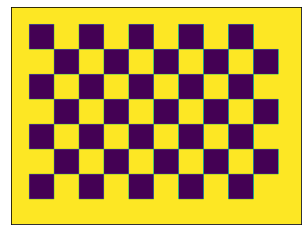

In [341]:
# pattern_image = cv.imread('pattern.png', 0)
plt.imshow(pattern_image)
plt.xticks([]), plt.yticks([])
plt.show()


In [342]:
status, corners = cv.findChessboardCorners(pattern_image, (6, 9))
if status:
    #print(corners)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_COUNT, 300, 0.01)
    cv.cornerSubPix(pattern_image, corners, (5, 5), (-1, -1), criteria)
else:
    print("Could not detect corners")

In [344]:
corners = corners.reshape(-1, 2)
print(corners.shape)
print(pattern_corners.shape)
print(pattern_corners - corners)

#print(((corners - pattern_points)))

(54, 2)
(54, 2)
[[ 5.000e-01 -2.745e+02]
 [ 5.550e+01 -2.195e+02]
 [ 1.105e+02 -1.645e+02]
 [ 1.655e+02 -1.095e+02]
 [ 2.205e+02 -5.450e+01]
 [ 2.755e+02  5.000e-01]
 [ 2.755e+02 -2.745e+02]
 [ 3.305e+02 -2.195e+02]
 [-5.450e+01 -1.095e+02]
 [ 5.000e-01 -5.450e+01]
 [ 5.550e+01  5.000e-01]
 [ 1.105e+02  5.550e+01]
 [ 1.105e+02 -2.195e+02]
 [ 1.655e+02 -1.645e+02]
 [ 2.205e+02 -1.095e+02]
 [ 2.755e+02 -5.450e+01]
 [-1.095e+02  5.550e+01]
 [-5.450e+01  1.105e+02]
 [-5.450e+01 -1.645e+02]
 [ 5.000e-01 -1.095e+02]
 [ 5.550e+01 -5.450e+01]
 [ 1.105e+02  5.000e-01]
 [ 1.655e+02  5.550e+01]
 [ 2.205e+02  1.105e+02]
 [-2.195e+02 -1.095e+02]
 [-1.645e+02 -5.450e+01]
 [-1.095e+02  5.000e-01]
 [-5.450e+01  5.550e+01]
 [ 5.000e-01  1.105e+02]
 [ 5.550e+01  1.655e+02]
 [ 5.550e+01 -1.095e+02]
 [ 1.105e+02 -5.450e+01]
 [-2.745e+02  5.550e+01]
 [-2.195e+02  1.105e+02]
 [-1.645e+02  1.655e+02]
 [-1.095e+02  2.205e+02]
 [-1.095e+02 -5.450e+01]
 [-5.450e+01  5.000e-01]
 [ 5.000e-01  5.550e+01]
 [ 5.550e